# Mapping pings to areas of interest

Load the necessary libraries.

In [1]:
import os

import datablox_od
import geopandas as gpd
import pandas as pd

pd.set_option("display.max_rows", 5)

%load_ext autoreload
%autoreload 2

Folder names

In [2]:
SAMPLE_DATA_DIRECTORY = os.path.join("..", "sample_data")
SAMPLE_OUTPUT_DIRECTORY = os.path.join("..", "sample_output")

<hr>

## I. Performing geospatial indexing

Mappings pings directly to areas of interest can be time-consuming for large datasets. To speed this up, we first have to perform geospatial indexing, which transforms the mapping process from pings → areas to **pings → cells (from the geospatial index) → areas**.

In the first part of this tutorial, we will learn how to use DataBlox-OD to map H3 cells to subdistricts in Thailand. [H3](https://h3geo.org/) is a widely used geospatial indexing system developed by Uber.

```{note}
We only need to perform geospatial indexing once, that is, at the start.
```

Load the data files specifying the geographic boundaries.

In [3]:
BOUNDARIES_DIRECTORY = os.path.join(SAMPLE_DATA_DIRECTORY, "boundaries")
adm0 = gpd.read_file(os.path.join(BOUNDARIES_DIRECTORY, "thailand_adm0.geojson"))
adm1 = gpd.read_file(os.path.join(BOUNDARIES_DIRECTORY, "thailand_adm1.geojson"))
adm3 = gpd.read_file(os.path.join(BOUNDARIES_DIRECTORY, "thailand_adm3.geojson"))

country_boundary = adm0["geometry"].to_numpy()[0]

Just for visualization purposes, we are going to spatially index the first-level administrative areas (provinces) in Thailand at an [H3 resolution](https://h3geo.org/docs/core-library/restable/) of 5 (with an average hexagon area of 252.90 km<sup>2</sup>). 

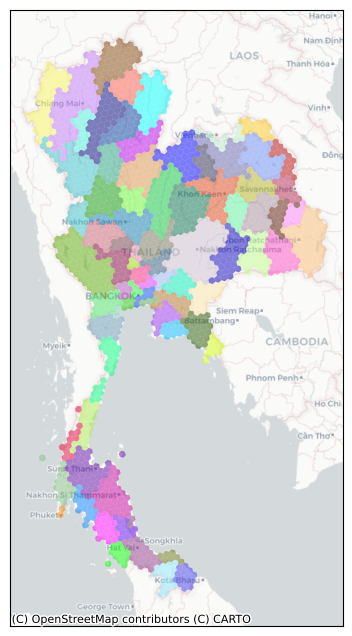

In [4]:
h3_to_area = datablox_od.preprocessing.perform_geospatial_indexing(
    country_boundary,
    adm1,
    spatial_index_column="h3_cell",
    spatial_indexing_system="h3",
    spatial_index_resolution=5,
    visualize=True,
    visualization_column="ADM1_EN",
    verbose=False,
)

For the actual tutorial, we are going to spatially index the third-level administrative areas (subdistricts) at a more granular H3 resolution of 8 (with an average hexagon area of 0.73 km<sup>2</sup>).

In [5]:
h3_to_area = datablox_od.preprocessing.perform_geospatial_indexing(
    country_boundary,
    adm3,
    spatial_index_column="h3_cell",
    spatial_indexing_system="h3",
    spatial_index_resolution=8,
    verbose=False,
)

# Keep only the relevant columns
h3_to_area = h3_to_area[["h3_cell", "ADM1_EN", "ADM2_EN", "ADM3_EN"]]
h3_to_area

,h3_cell,ADM1_EN,ADM2_EN,ADM3_EN
0,8865190413fffff,Satun,Mueang Satun,Ko Sarai
1,8865190411fffff,Satun,Mueang Satun,Ko Sarai
...,...,...,...,...
597931,88648630b3fffff,Lampang,Soem Ngam,Soem Sai
597932,886593b84dfffff,Ubon Ratchathani,Det Udom,Kham Khrang


Export the results to a Parquet file.

In [6]:
os.makedirs(SAMPLE_OUTPUT_DIRECTORY, exist_ok=True)
h3_to_area.to_parquet(os.path.join(SAMPLE_OUTPUT_DIRECTORY, "h3_to_area.parquet"))

<hr>

## II. Mappings pings to areas of interest

Recall that our mapping process is **pings → cells (from the geospatial index) → areas**. Now that we have generated the H3 cell-to-area mapping, we are now ready to map our pings to our areas of interest (subdistricts in Thailand).

In [7]:
h3_to_area = pd.read_parquet(
    os.path.join(SAMPLE_OUTPUT_DIRECTORY, "h3_to_area.parquet")
)

Load the data files containing the pings.

In [8]:
ping_data_frames = []

PING_DIRECTORY = os.path.join(SAMPLE_DATA_DIRECTORY, "pings")

for dirpath, dirnames, filenames in os.walk(PING_DIRECTORY):
    for file in filenames:
        ping_data_frames.append(pd.read_parquet(os.path.join(dirpath, file)))

pings = pd.concat(ping_data_frames)[
    ["device_id", "longitude", "latitude", "horizontal_accuracy", "timestamp"]
]
pings

,device_id,longitude,latitude,horizontal_accuracy,timestamp
107,AFBDE0F7-34DF-4B2B-9227-1FF9C45C1879,103.164131,14.728149,3.0,1546338274000
230,AFBDE0F7-34DF-4B2B-9227-1FF9C45C1879,102.068939,15.199890,3.0,1546308269000
...,...,...,...,...,...
135532,4CCB1986-85B2-42E6-987F-664A9D24EBA5,100.454269,13.895766,16.0,1577826577000
135551,4CCB1986-85B2-42E6-987F-664A9D24EBA5,100.454330,13.895577,16.0,1577804019000


To make the data frame compatible with DataBlox-OD's `datablox_od.preprocessing.map_pings_to_areas()`, we need to make some transformations:
- The data frame should be a `geopandas.GeoDataFrame`.
- The coordinates for each ping should be stored as a `shapely.Point` object.
- The timestamp for each ping should be stored as a `pandas.Timestamp` object.

In [9]:
pings = gpd.GeoDataFrame(
    pings,
    geometry=gpd.points_from_xy(pings["longitude"], pings["latitude"]),
    crs=4326,
).drop(["longitude", "latitude"], axis=1)
pings["timestamp"] = pd.to_datetime(pings["timestamp"], unit="ms")
pings

,device_id,horizontal_accuracy,timestamp,geometry
107,AFBDE0F7-34DF-4B2B-9227-1FF9C45C1879,3.0,2019-01-01 10:24:34,POINT (103.16413 14.72815)
230,AFBDE0F7-34DF-4B2B-9227-1FF9C45C1879,3.0,2019-01-01 02:04:29,POINT (102.06894 15.19989)
...,...,...,...,...
135532,4CCB1986-85B2-42E6-987F-664A9D24EBA5,16.0,2019-12-31 21:09:37,POINT (100.45427 13.89577)
135551,4CCB1986-85B2-42E6-987F-664A9D24EBA5,16.0,2019-12-31 14:53:39,POINT (100.45433 13.89558)


Map the pings to the areas.

In [10]:
pings = datablox_od.preprocessing.map_pings_to_areas(
    pings,
    h3_to_area,
    spatial_index_column="h3_cell",
    device_id_column="device_id",
    coordinates_column="geometry",
    timestamp_column="timestamp",
    adjust_timezone=7,
    spatial_indexing_system="h3",
    spatial_index_resolution=8,
    verbose=False,
)
pings

,device_id,horizontal_accuracy,timestamp,geometry,h3_cell,ADM1_EN,ADM2_EN,ADM3_EN
0,AFBDE0F7-34DF-4B2B-9227-1FF9C45C1879,3.0,2019-01-01 17:24:34,POINT (103.16413 14.72815),8865981a25fffff,Buri Ram,Phlapphla Chai,Sadao
1,AFBDE0F7-34DF-4B2B-9227-1FF9C45C1879,3.0,2019-01-01 09:04:29,POINT (102.06894 15.19989),88659bba05fffff,Nakhon Ratchasima,Non Thai,Non Thai
...,...,...,...,...,...,...,...,...
28897519,4CCB1986-85B2-42E6-987F-664A9D24EBA5,16.0,2020-01-01 04:09:37,POINT (100.45427 13.89577),8864a4aa49fffff,Nonthaburi,Pak Kret,Tha It
28897520,4CCB1986-85B2-42E6-987F-664A9D24EBA5,16.0,2019-12-31 21:53:39,POINT (100.45433 13.89558),8864a4aa49fffff,Nonthaburi,Pak Kret,Tha It


Create a unique identifier for each area. This is so that we can handle cases such as same-name districts belonging to different provinces.

In [11]:
pings["ADM2_EN"] = pings["ADM1_EN"] + "#" + pings["ADM2_EN"]
pings["ADM3_EN"] = pings["ADM2_EN"] + "#" + pings["ADM3_EN"]
pings

,device_id,horizontal_accuracy,timestamp,geometry,h3_cell,ADM1_EN,ADM2_EN,ADM3_EN
0,AFBDE0F7-34DF-4B2B-9227-1FF9C45C1879,3.0,2019-01-01 17:24:34,POINT (103.16413 14.72815),8865981a25fffff,Buri Ram,Buri Ram#Phlapphla Chai,Buri Ram#Phlapphla Chai#Sadao
1,AFBDE0F7-34DF-4B2B-9227-1FF9C45C1879,3.0,2019-01-01 09:04:29,POINT (102.06894 15.19989),88659bba05fffff,Nakhon Ratchasima,Nakhon Ratchasima#Non Thai,Nakhon Ratchasima#Non Thai#Non Thai
...,...,...,...,...,...,...,...,...
28897519,4CCB1986-85B2-42E6-987F-664A9D24EBA5,16.0,2020-01-01 04:09:37,POINT (100.45427 13.89577),8864a4aa49fffff,Nonthaburi,Nonthaburi#Pak Kret,Nonthaburi#Pak Kret#Tha It
28897520,4CCB1986-85B2-42E6-987F-664A9D24EBA5,16.0,2019-12-31 21:53:39,POINT (100.45433 13.89558),8864a4aa49fffff,Nonthaburi,Nonthaburi#Pak Kret,Nonthaburi#Pak Kret#Tha It


Export the results to a Parquet file. This file will be used in the subsequent tutorials.

In [12]:
pings.to_parquet(os.path.join(SAMPLE_OUTPUT_DIRECTORY, "pings.parquet"))